In [1]:
import joblib
import os
import pandas as pd
import pandas_ta as ta
import numpy as np
import polars as pl
from pathlib import Path
import sys
import datetime
import numpy as np


## **Carga de Datos Inicial**
## **División Entrenamiento/Prueba (Temporal)**
## **Remuestreo de velas**



In [ ]:
BASE_PATH = Path("src")
DATA_FILE = BASE_PATH / "eurusd_5s_2021_2025_07_18utc.parquet"
def block_1_load_data():
    print(">>> [BLOQUE 1] Carga de Datos 5s...")
    if not DATA_FILE.exists(): raise FileNotFoundError(f"No se encuentra {DATA_FILE}")
    df = pl.scan_parquet(str(DATA_FILE)).filter((pl.col("ts").dt.time() >= pl.time(7,0,0)) & (pl.col("ts").dt.time() <= pl.time(18,0,0))).sort("ts").collect()
    print(f"Dataset shape: {df.shape}")
    print("✅ [BLOQUE 1] PASS")
    return df
df_5s = block_1_load_data()
def block_2_split_train_test(df_5s: pl.DataFrame):
    print("\n>>> [BLOQUE 2] Split Train/Test...")
    split_date = datetime.date(2025, 7, 1)
    df_train = df_5s.filter(pl.col("ts").dt.date() < split_date)
    df_test = df_5s.filter(pl.col("ts").dt.date() >= split_date)
    print(f"Train Shape: {df_train.shape}, Test Shape: {df_test.shape}")
    if df_train.height == 0 or df_test.height == 0: raise ValueError("Empty split")
    print("✅ [BLOQUE 2] PASS")
    return df_train, df_test
df_train, df_test = block_2_split_train_test(df_5s)
def resample_ohlcv_microstructure(df_5s, every, ts_col="ts"):
    df_5s = df_5s.sort(ts_col)
    return df_5s.group_by_dynamic(ts_col, every=every, closed="left", label="left", start_by="window").agg([
        pl.col("open").first().alias("open"), pl.col("high").max().alias("high"), pl.col("low").min().alias("low"), pl.col("close").last().alias("close"),
        pl.col("ticks").sum().alias("ticks"), pl.col("bid_vol_sum").sum().alias("bid_vol_sum"), pl.col("ask_vol_sum").sum().alias("ask_vol_sum"),
        pl.col("bid_last").last().alias("bid_last"), pl.col("ask_last").last().alias("ask_last"),
        pl.len().alias("n_bars_5s")
    ]).sort(ts_col)
def block_3_resample(df_train, df_test):
    print("\n>>> [BLOQUE 3] Resample M3...")
    df_train_m3 = resample_ohlcv_microstructure(df_train, "3m")
    df_test_m3 = resample_ohlcv_microstructure(df_test, "3m")
    print(f"Train M3: {df_train_m3.shape}, Test M3: {df_test_m3.shape}")
    print("✅ [BLOQUE 3] PASS")
    return df_train_m3, df_test_m3
df_train_m3, df_test_m3 = block_3_resample(df_train, df_test)


>>> [BLOQUE 1] Carga de Datos 5s...
Dataset shape: (8449570, 10)
✅ [BLOQUE 1] PASS

>>> [BLOQUE 2] Split Train/Test...
Train Shape: (7718101, 10), Test Shape: (731469, 10)
✅ [BLOQUE 2] PASS

>>> [BLOQUE 3] Resample M3...
Train M3: (233418, 11), Test M3: (23339, 11)
✅ [BLOQUE 3] PASS


# Etiqueta

In [ ]:
path_trades='train_results_M3_final.csv'
df_trades_pl = pl.read_csv(path_trades)
df_trades_pl = df_trades_pl.filter(pl.col('signal') == 1)
time_cols = ['signal_ts', 'entry_ts_real', 'exit_price_ts']
for col in time_cols:
    df_trades_pl = df_trades_pl.with_columns(pl.col(col).str.to_datetime().cast(pl.Datetime('ms')))
keep_cols = [
    'signal_ts', 
    'target_15p', 
    'pnl_pips_net', 
    'mae_pips', 
    'mfe_pips', 
    'exit_reason'
]
df_ml_labels = (
    df_trades_pl
    .filter(pl.col('entry_allowed') == True)
    .select(keep_cols)
    .drop_nulls(subset=['target_15p'])
    .with_columns(pl.col('target_15p').cast(pl.Int8))
)
print('Trades Shape (Longs):', df_ml_labels.shape)
print(df_ml_labels.head())
df_ml_labels.schema


Trades Shape (Longs): (1568, 6)
shape: (5, 6)
┌─────────────────────┬────────────┬──────────────┬──────────┬──────────┬─────────────┐
│ signal_ts           ┆ target_15p ┆ pnl_pips_net ┆ mae_pips ┆ mfe_pips ┆ exit_reason │
│ ---                 ┆ ---        ┆ ---          ┆ ---      ┆ ---      ┆ ---         │
│ datetime[ms]        ┆ i8         ┆ f64          ┆ f64      ┆ f64      ┆ str         │
╞═════════════════════╪════════════╪══════════════╪══════════╪══════════╪═════════════╡
│ 2021-01-01 10:36:00 ┆ 1          ┆ 8.8          ┆ 3.65     ┆ 15.6     ┆ TP          │
│ 2021-01-01 13:57:00 ┆ 0          ┆ 9.5          ┆ 5.0      ┆ 14.65    ┆ TP          │
│ 2021-01-02 09:21:00 ┆ 0          ┆ -11.0        ┆ 44.0     ┆ 3.05     ┆ SL          │
│ 2021-01-02 12:45:00 ┆ 1          ┆ 9.25         ┆ 7.1      ┆ 18.75    ┆ TP          │
│ 2021-01-02 15:30:00 ┆ 0          ┆ -9.95        ┆ 15.55    ┆ 3.95     ┆ SL          │
└─────────────────────┴────────────┴──────────────┴──────────┴──────────┴─

Schema([('signal_ts', Datetime(time_unit='ms', time_zone=None)),
        ('target_15p', Int8),
        ('pnl_pips_net', Float64),
        ('mae_pips', Float64),
        ('mfe_pips', Float64),
        ('exit_reason', String)])

# Features

**Ingeniería de Características**: 
*   **Momentum**: RSI y sus pendientes.
*   **Tendencia**: Distancia a medias móviles exponenciales (EMA 20, 200).
*   **Volatilidad**: Ratio ATR para medir regímenes de volatilidad.
*   **Microestructura**: Desequilibrio de volumen (Bid vs Ask) e intensidad de ticks.
*   **Estacionalidad**: Hora del día.


In [9]:
import polars as pl
import numpy as np
def calculate_ml_features(df: pl.DataFrame) -> pl.DataFrame:
    print(">>> Calculando Features para ML...")
    df = df.sort("ts")
    rsi_period = 14
    ema_fast_p = 20
    ema_slow_p = 200
    atr_period = 14
    vol_regime_p = 100
    df = df.with_columns([
        (pl.col("close").diff()).alias("diff"),
        (pl.col("high") - pl.col("low")).alias("range"),
        (pl.col("close") - pl.col("open")).alias("body_size"),
    ])
    df = df.with_columns([
        pl.when(pl.col("diff") >= 0).then(pl.col("diff")).otherwise(0).alias("gain"),
        pl.when(pl.col("diff") < 0).then(-pl.col("diff")).otherwise(0).alias("loss"),
    ])
    df = df.with_columns([
        pl.col("gain").rolling_mean(window_size=rsi_period).alias("avg_gain"),
        pl.col("loss").rolling_mean(window_size=rsi_period).alias("avg_loss"),
    ])
    df = df.with_columns([
        (100 - (100 / (1 + (pl.col("avg_gain") / (pl.col("avg_loss") + 1e-9))))).alias("rsi_14")
    ])
    df = df.with_columns([
        pl.col("close").ewm_mean(span=ema_fast_p).alias("ema_20"),
        pl.col("close").ewm_mean(span=ema_slow_p).alias("ema_200"),
    ])
    df = df.with_columns([
        (pl.col("rsi_14") - pl.col("rsi_14").shift(1)).alias("rsi_slope"),
        ((pl.col("close") / pl.col("ema_20")) - 1).alias("dist_ema_20"),
        ((pl.col("close") / pl.col("ema_200")) - 1).alias("dist_ema_200"),
        (pl.col("range").rolling_mean(window_size=atr_period) / 
         pl.col("range").rolling_mean(window_size=vol_regime_p)).alias("vol_regime_ratio"),
        (pl.col("bid_vol_sum") / (pl.col("ask_vol_sum") + 1e-9)).alias("vol_imbalance"),
        (pl.col("ticks") / pl.col("ticks").rolling_mean(window_size=20)).alias("relative_tick_intensity"),
        pl.col("ts").dt.hour().alias("hour"),
    ])
    cols_to_drop = ["diff", "gain", "loss", "avg_gain", "avg_loss"]
    df = df.drop(cols_to_drop).drop_nulls()
    print(f"✅ Features calculadas. Columnas totales: {len(df.columns)}")
    return df
df_features = calculate_ml_features(df_train_m3)
df_final_ml = (
    df_features.rename({"ts": "signal_ts"})
    .join(df_ml_labels, on="signal_ts", how="inner")
)
print(f"\n>>> [DATASET FINAL] Listo para entrenar")
print(f"Registros con señal y features: {df_final_ml.height}")
print(df_final_ml.head())


>>> Calculando Features para ML...
✅ Features calculadas. Columnas totales: 23

>>> [DATASET FINAL] Listo para entrenar
Registros con señal y features: 1567
shape: (5, 28)
┌─────────────┬──────────┬──────────┬──────────┬───┬────────────┬──────────┬──────────┬────────────┐
│ signal_ts   ┆ open     ┆ high     ┆ low      ┆ … ┆ pnl_pips_n ┆ mae_pips ┆ mfe_pips ┆ exit_reaso │
│ ---         ┆ ---      ┆ ---      ┆ ---      ┆   ┆ et         ┆ ---      ┆ ---      ┆ n          │
│ datetime[ms ┆ f64      ┆ f64      ┆ f64      ┆   ┆ ---        ┆ f64      ┆ f64      ┆ ---        │
│ ]           ┆          ┆          ┆          ┆   ┆ f64        ┆          ┆          ┆ str        │
╞═════════════╪══════════╪══════════╪══════════╪═══╪════════════╪══════════╪══════════╪════════════╡
│ 2021-01-01  ┆ 1.208735 ┆ 1.208975 ┆ 1.20835  ┆ … ┆ 9.5        ┆ 5.0      ┆ 14.65    ┆ TP         │
│ 13:57:00    ┆          ┆          ┆          ┆   ┆            ┆          ┆          ┆            │
│ 2021-01-02  ┆ 1.20

In [10]:
df_final_ml


signal_ts,open,high,low,close,ticks,bid_vol_sum,ask_vol_sum,bid_last,ask_last,n_bars_5s,range,body_size,rsi_14,ema_20,ema_200,rsi_slope,dist_ema_20,dist_ema_200,vol_regime_ratio,vol_imbalance,relative_tick_intensity,hour,target_15p,pnl_pips_net,mae_pips,mfe_pips,exit_reason
datetime[ms],f64,f64,f64,f64,u32,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,f64,f64,f64,str
2021-01-01 13:57:00,1.208735,1.208975,1.20835,1.208485,371,774.230006,364.77,1.20848,1.20849,36,0.000625,-0.00025,42.652817,1.208458,1.209005,-13.801599,0.000022,-0.00043,1.071835,2.122516,1.142593,13,0,9.5,5.0,14.65,"""TP"""
2021-01-02 09:21:00,1.207835,1.20796,1.207455,1.207605,238,403.030002,400.520005,1.20759,1.20762,35,0.000505,-0.00023,40.889966,1.207928,1.208044,-3.796897,-0.000268,-0.000363,1.124286,1.006267,0.86798,9,0,-11.0,44.0,3.05,"""SL"""
2021-01-02 12:45:00,1.203255,1.20334,1.203,1.203095,169,304.870003,278.789999,1.20308,1.20311,33,0.00034,-0.00016,49.743233,1.203407,1.206046,-5.750846,-0.000259,-0.002447,0.673625,1.093547,0.887605,12,1,9.25,7.1,18.75,"""TP"""
2021-01-02 15:30:00,1.203005,1.20318,1.20287,1.20289,322,436.430002,455.510003,1.20288,1.2029,36,0.00031,-0.000115,54.931296,1.2031,1.205002,-2.631503,-0.000175,-0.001752,1.279722,0.958113,0.70645,15,0,-9.95,15.55,3.95,"""SL"""
2021-01-03 10:15:00,1.201865,1.202045,1.201725,1.201725,166,389.760001,226.78,1.20171,1.20174,32,0.00032,-0.00014,25.359585,1.202324,1.203444,-4.712727,-0.000498,-0.001428,1.124056,1.71867,0.711225,10,0,-9.0,8.9,7.2,"""TIME"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-06-28 12:15:00,1.16554,1.16599,1.165385,1.165395,249,305.249997,399.859997,1.16536,1.16543,36,0.000605,-0.000145,56.241211,1.16544,1.169061,-4.811196,-0.000038,-0.003136,1.209356,0.763392,0.819753,12,0,8.7,28.05,11.25,"""TP"""
2025-06-28 15:03:00,1.1636,1.163915,1.16333,1.16337,273,412.809994,379.629995,1.16335,1.16339,35,0.000585,-0.00023,49.494716,1.163886,1.16703,-1.993648,-0.000443,-0.003137,0.974674,1.087401,1.027281,15,0,-10.6,37.2,0.5,"""SL"""
2025-06-29 13:30:00,1.152815,1.15299,1.152495,1.152535,197,264.429997,238.019996,1.15252,1.15255,31,0.000495,-0.00028,38.195171,1.152914,1.15763,-9.11006,-0.000329,-0.004401,1.173668,1.110957,1.041777,13,1,9.25,5.8,26.35,"""TP"""


In [11]:
df_final_ml.schema


Schema([('signal_ts', Datetime(time_unit='ms', time_zone=None)),
        ('open', Float64),
        ('high', Float64),
        ('low', Float64),
        ('close', Float64),
        ('ticks', UInt32),
        ('bid_vol_sum', Float64),
        ('ask_vol_sum', Float64),
        ('bid_last', Float64),
        ('ask_last', Float64),
        ('n_bars_5s', UInt32),
        ('range', Float64),
        ('body_size', Float64),
        ('rsi_14', Float64),
        ('ema_20', Float64),
        ('ema_200', Float64),
        ('rsi_slope', Float64),
        ('dist_ema_20', Float64),
        ('dist_ema_200', Float64),
        ('vol_regime_ratio', Float64),
        ('vol_imbalance', Float64),
        ('relative_tick_intensity', Float64),
        ('hour', Int8),
        ('target_15p', Int8),
        ('pnl_pips_net', Float64),
        ('mae_pips', Float64),
        ('mfe_pips', Float64),
        ('exit_reason', String)])

# MACHINE LEARNING

**Entrenamiento de Modelos Base**: Inicializa y entrena cuatro modelos de clasificación populares, imprimiendo los resultados preliminares.


**Análisis de Importancia de Features**: Extrae y visualiza qué variables (features) tienen mayor peso en las decisiones de los modelos Random Forest y CatBoost optimizados.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
cols_to_drop = [
    'signal_ts', 'open', 'high', 'low', 'close', 'bid_last', 'ask_last',
    'n_bars_5s', 'ticks', 'bid_vol_sum', 'ask_vol_sum', 
    'ema_20', 'ema_200', 
    'pnl_pips_net', 'mae_pips', 'mfe_pips', 'exit_reason', 'target_15p'
]
X = df_final_ml.drop(cols_to_drop).to_pandas()
y = df_final_ml.select('target_15p').to_pandas().values.ravel()
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.03, max_depth=5, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.03, importance_type='gain', verbose=-1),
    "CatBoost": CatBoostClassifier(iterations=200, learning_rate=0.03, depth=5, verbose=0)
}
results = {}
feature_importances = pd.DataFrame(index=X.columns)
print(f"Iniciando validación de Edge en {len(X.columns)} variables...")
print(f"Registros de entrenamiento: {len(X_train)} | Registros de test: {len(X_test)}")
print("-" * 60)
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_probs)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results[name] = {'AUC': auc, 'Precision': prec, 'Recall': rec, 'F1': f1}
    imp = model.feature_importances_
    feature_importances[name] = imp / imp.sum()
    print(f"[{name}] AUC: {auc:.4f} | Prec: {prec:.2%} | Rec: {rec:.2%} | F1: {f1:.4f}")
feature_importances['Consensus'] = feature_importances.mean(axis=1)
top_features = feature_importances.sort_values(by='Consensus', ascending=False).head(10)
print("\n" + "="*30)
print("TOP 10 VARIABLES (CONSENSO)")
print("="*30)
print(top_features['Consensus'])


Iniciando validación de Edge en 10 variables...
Registros de entrenamiento: 1253 | Registros de test: 314
------------------------------------------------------------
[RandomForest] AUC: 0.5932 | Prec: 70.00% | Rec: 15.79% | F1: 0.2577
[XGBoost] AUC: 0.5816 | Prec: 52.08% | Rec: 18.80% | F1: 0.2762
[LightGBM] AUC: 0.5716 | Prec: 45.45% | Rec: 22.56% | F1: 0.3015
[CatBoost] AUC: 0.6220 | Prec: 69.44% | Rec: 18.80% | F1: 0.2959

TOP 10 VARIABLES (CONSENSO)
range                      0.135134
dist_ema_20                0.110929
body_size                  0.101123
vol_imbalance              0.097844
rsi_14                     0.096006
relative_tick_intensity    0.095548
vol_regime_ratio           0.093029
dist_ema_200               0.091697
rsi_slope                  0.090981
hour                       0.087708
Name: Consensus, dtype: float64


# Random Hiperparametros

In [13]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 8, 12, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid_rf, 
    cv=tscv, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1
)
print("Iniciando Fine-Tuning de RandomForest...")
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print(f"\nMejores parámetros: {grid_search_rf.best_params_}")
y_probs_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = best_rf.predict(X_test)
new_auc = roc_auc_score(y_test, y_probs_rf)
new_prec = precision_score(y_test, y_pred_rf)
print("-" * 30)
print(f"RF POST-TUNING - AUC: {new_auc:.4f} | Precisión: {new_prec:.2%}")
print(f"Señales ejecutadas: {sum(y_pred_rf)} de {len(y_test)}")


Iniciando Fine-Tuning de RandomForest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits



Mejores parámetros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
------------------------------
RF POST-TUNING - AUC: 0.6175 | Precisión: 73.91%
Señales ejecutadas: 23 de 314


# Catboost tuning

In [14]:
from catboost import CatBoostClassifier
param_grid_cb = {
    'iterations': [200, 500],
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 50]
}
cb = CatBoostClassifier(verbose=0, random_state=42)
grid_search_cb = GridSearchCV(
    estimator=cb, 
    param_grid=param_grid_cb, 
    cv=tscv, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1
)
print("Iniciando Fine-Tuning de CatBoost (Esto puede tardar unos minutos)...")
grid_search_cb.fit(X_train, y_train)
best_cb = grid_search_cb.best_estimator_
print(f"\nMejores parámetros CatBoost: {grid_search_cb.best_params_}")
y_probs_cb = best_cb.predict_proba(X_test)[:, 1]
print(f"CatBoost POST-TUNING - AUC: {roc_auc_score(y_test, y_probs_cb):.4f}")


Iniciando Fine-Tuning de CatBoost (Esto puede tardar unos minutos)...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Mejores parámetros CatBoost: {'border_count': 50, 'depth': 4, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.01}
CatBoost POST-TUNING - AUC: 0.6290


In [15]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
param_grid_cb = {
    'iterations': [200, 500],
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [32, 64],
    'random_strength': [1, 2]
}
cb = CatBoostClassifier(verbose=0, random_state=42, bootstrap_type='Bernoulli')
grid_search_cb = GridSearchCV(
    estimator=cb, 
    param_grid=param_grid_cb, 
    cv=tscv, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1
)
print("Iniciando Fine-Tuning de CatBoost...")
grid_search_cb.fit(X_train, y_train)
best_cb = grid_search_cb.best_estimator_
print(f"\nMejores parámetros CatBoost: {grid_search_cb.best_params_}")
y_probs_cb = best_cb.predict_proba(X_test)[:, 1]
y_pred_cb = best_cb.predict(X_test)
new_auc_cb = roc_auc_score(y_test, y_probs_cb)
new_prec_cb = precision_score(y_test, y_pred_cb, zero_division=0)
new_rec_cb = recall_score(y_test, y_pred_cb, zero_division=0)
print("-" * 50)
print(f"CATBOOST POST-TUNING")
print(f"AUC (Edge):      {new_auc_cb:.4f}")
print(f"Precisión C1:    {new_prec_cb:.2%}")
print(f"Recall C1:       {new_rec_cb:.2%}")
print(f"Señales dadas:   {sum(y_pred_cb)} de {len(y_test)}")


Iniciando Fine-Tuning de CatBoost...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Mejores parámetros CatBoost: {'border_count': 64, 'depth': 4, 'iterations': 200, 'l2_leaf_reg': 7, 'learning_rate': 0.01, 'random_strength': 1}
--------------------------------------------------
CATBOOST POST-TUNING
AUC (Edge):      0.6326
Precisión C1:    71.43%
Recall C1:       7.52%
Señales dadas:   14 de 314


# Features por mejor modelo

## Random


=== TOP 10 FEATURES (Random Forest Final) ===
                Feature  Importance
                  range    0.201082
            dist_ema_20    0.147579
              body_size    0.131283
       vol_regime_ratio    0.094603
           dist_ema_200    0.080472
          vol_imbalance    0.079266
                 rsi_14    0.071144
              rsi_slope    0.068872
relative_tick_intensity    0.068292
                   hour    0.057408


/var/folders/l8/j7p44fhj15l57k7pck7kcm340000gn/T/ipykernel_7031/3383338546.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_feat_imp.head(10), palette='viridis')


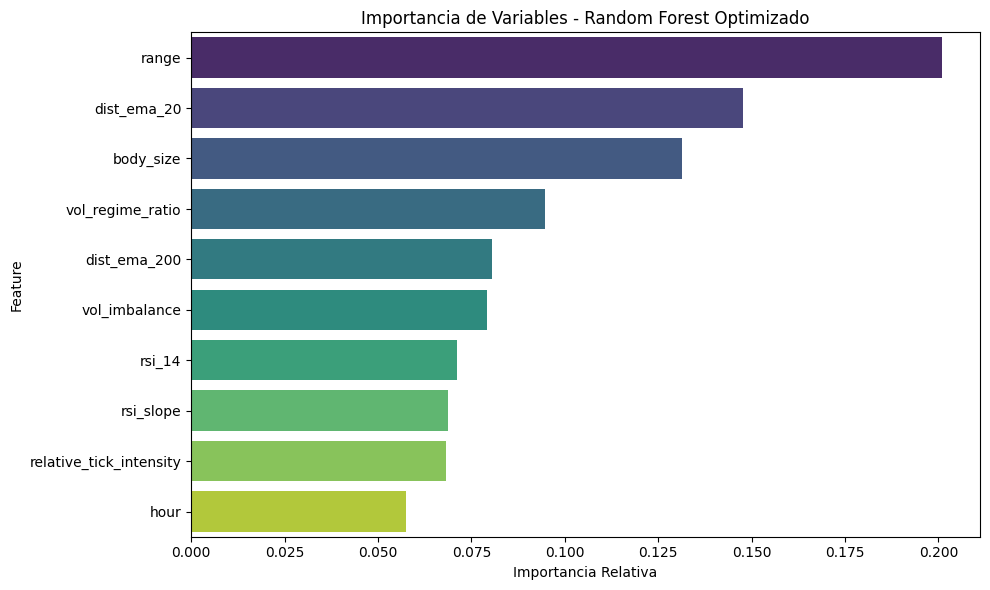

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
importances = best_rf.feature_importances_
feature_names = X_train.columns
rf_feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("\n=== TOP 10 FEATURES (Random Forest Final) ===")
print(rf_feat_imp.head(10).to_string(index=False))
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_feat_imp.head(10), palette='viridis')
plt.title('Importancia de Variables - Random Forest Optimizado')
plt.xlabel('Importancia Relativa')
plt.tight_layout()
plt.show()


## Cat


=== TOP 10 FEATURES (CatBoost Final) ===
                Feature  Importance
                  range   25.479756
              body_size   14.316706
            dist_ema_20   13.140611
                   hour   11.383268
              rsi_slope    7.312926
       vol_regime_ratio    7.114140
           dist_ema_200    5.671526
relative_tick_intensity    5.597038
                 rsi_14    5.359440
          vol_imbalance    4.624589


/var/folders/l8/j7p44fhj15l57k7pck7kcm340000gn/T/ipykernel_7031/1388350110.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=cb_feat_imp.head(10), palette='magma')


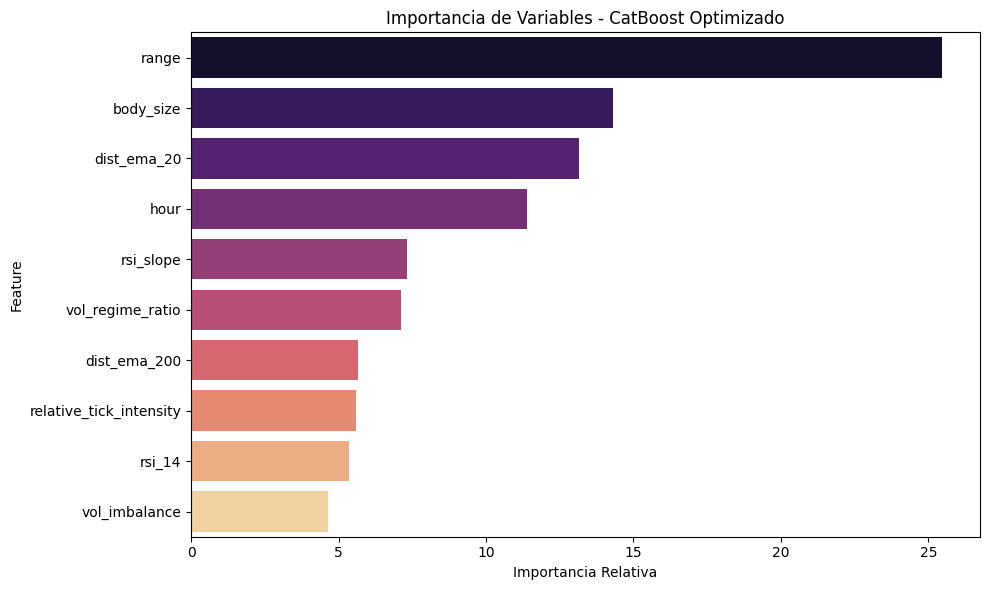

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
importances = best_cb.feature_importances_
feature_names = X_train.columns
cb_feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("\n=== TOP 10 FEATURES (CatBoost Final) ===")
print(cb_feat_imp.head(10).to_string(index=False))
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=cb_feat_imp.head(10), palette='magma')
plt.title('Importancia de Variables - CatBoost Optimizado')
plt.xlabel('Importancia Relativa')
plt.tight_layout()
plt.show()


# Validacion nuevos datos

# Features nuevos datos

## ETIQUETA

In [ ]:
import polars as pl
PATH_TRADES_OOS = 'test_results_M3_final.csv'
def load_oos_labels(path):
    print(f">>> Cargando etiquetas de validación OOS desde: {path}")
    df_raw = pl.read_csv(path)
    time_cols = ['signal_ts', 'entry_ts_real', 'exit_price_ts']
    df_processed = (
        df_raw
        .filter(pl.col('signal') == 1) 
        .with_columns([
            pl.col(col).str.to_datetime().cast(pl.Datetime('ms')) 
            for col in time_cols
        ])
    )
    keep_cols_oos = [
        'signal_ts', 
        'target_15p', 
        'pnl_pips_net', 
        'mae_pips', 
        'mfe_pips', 
        'exit_reason'
    ]
    df_labels_oos = (
        df_processed
        .filter(pl.col('entry_allowed') == True)
        .select(keep_cols_oos)
        .drop_nulls(subset=['target_15p'])
        .with_columns(pl.col('target_15p').cast(pl.Int8))
    )
    print(f"✅ Etiquetas OOS cargadas. Shape: {df_labels_oos.shape}")
    return df_labels_oos
df_ml_labels_oos = load_oos_labels(PATH_TRADES_OOS)
print("\nVista previa de etiquetas OOS:")
print(df_ml_labels_oos.head())


>>> Cargando etiquetas de validación OOS desde: /Users/rjsaavedra/Documents/Projects/ml_master_project/src/test_results_M3_final.csv
✅ Etiquetas OOS cargadas. Shape: (157, 6)

Vista previa de etiquetas OOS:
shape: (5, 6)
┌─────────────────────┬────────────┬──────────────┬──────────┬──────────┬─────────────┐
│ signal_ts           ┆ target_15p ┆ pnl_pips_net ┆ mae_pips ┆ mfe_pips ┆ exit_reason │
│ ---                 ┆ ---        ┆ ---          ┆ ---      ┆ ---      ┆ ---         │
│ datetime[ms]        ┆ i8         ┆ f64          ┆ f64      ┆ f64      ┆ str         │
╞═════════════════════╪════════════╪══════════════╪══════════╪══════════╪═════════════╡
│ 2025-07-04 09:00:00 ┆ 1          ┆ 8.95         ┆ 0.8      ┆ 21.55    ┆ TP          │
│ 2025-07-04 12:00:00 ┆ 1          ┆ 10.0         ┆ 2.7      ┆ 25.5     ┆ TP          │
│ 2025-07-05 09:00:00 ┆ 0          ┆ 9.0          ┆ 4.2      ┆ 12.3     ┆ TP          │
│ 2025-07-05 12:48:00 ┆ 1          ┆ 9.2          ┆ 2.9      ┆ 23.85    ┆ T

# Features

In [26]:
import polars as pl
from datetime import date
df_combined_m3 = pl.concat([df_train_m3, df_test_m3])
df_features_full = calculate_ml_features(df_combined_m3)
split_date_oos = date(2025, 7, 1)
df_features_oos = df_features_full.filter(pl.col("ts").dt.date() >= split_date_oos)
df_final_ml_oos = (
    df_features_oos.rename({"ts": "signal_ts"})
    .join(df_ml_labels_oos, on="signal_ts", how="inner")
)
print(f"\n>>> [DATASET VALIDACIÓN OOS] Listo")
print(f"Registros OOS con señal y features: {df_final_ml_oos.height}")
print(df_final_ml_oos.head())


>>> Calculando Features para ML...
✅ Features calculadas. Columnas totales: 23

>>> [DATASET VALIDACIÓN OOS] Listo
Registros OOS con señal y features: 157
shape: (5, 28)
┌─────────────┬─────────┬──────────┬──────────┬───┬─────────────┬──────────┬──────────┬────────────┐
│ signal_ts   ┆ open    ┆ high     ┆ low      ┆ … ┆ pnl_pips_ne ┆ mae_pips ┆ mfe_pips ┆ exit_reaso │
│ ---         ┆ ---     ┆ ---      ┆ ---      ┆   ┆ t           ┆ ---      ┆ ---      ┆ n          │
│ datetime[ms ┆ f64     ┆ f64      ┆ f64      ┆   ┆ ---         ┆ f64      ┆ f64      ┆ ---        │
│ ]           ┆         ┆          ┆          ┆   ┆ f64         ┆          ┆          ┆ str        │
╞═════════════╪═════════╪══════════╪══════════╪═══╪═════════════╪══════════╪══════════╪════════════╡
│ 2025-07-04  ┆ 1.1558  ┆ 1.156005 ┆ 1.15556  ┆ … ┆ 8.95        ┆ 0.8      ┆ 21.55    ┆ TP         │
│ 09:00:00    ┆         ┆          ┆          ┆   ┆             ┆          ┆          ┆            │
│ 2025-07-04  ┆ 1.1566

# Baseline

In [31]:
import polars as pl
import numpy as np
def calculate_strategy_metrics(df, name=""):
    df_exec = df.filter(pl.col("pnl_pips_net").is_not_null())
    if df_exec.height == 0: 
        print(f"--- {name}: No hay trades ejecutados ---")
        return None
    n_trades = df_exec.height
    n_win = df_exec.filter(pl.col("pnl_pips_net") > 0).height
    win_rate = (n_win / n_trades) * 100
    total_return_pips = df_exec["pnl_pips_net"].sum()
    avg_return_pips = df_exec["pnl_pips_net"].mean() 
    equity = df_exec["pnl_pips_net"].to_numpy().cumsum()
    high_water_mark = np.maximum.accumulate(equity)
    drawdowns = high_water_mark - equity
    max_dd_pips = np.max(drawdowns) if len(drawdowns) > 0 else 0
    print(f"--- {name} Baseline Metrics ---")
    print(f"Trades Totales: {n_trades}")
    print(f"Win Rate:       {win_rate:.2f}%")
    print(f"Esperanza:      {avg_return_pips:.2f} pips/trade")
    print(f"Retorno Total:  {total_return_pips:.2f} pips")
    print(f"Max Drawdown:   {max_dd_pips:.2f} pips")
    print("-" * 30)
    return {
        "trades": n_trades, "win_rate": win_rate, "expectancy": avg_return_pips,
        "total_return": total_return_pips, "max_dd": max_dd_pips
    }
print("Calculando Baselines del Sistema...")
metrics_train_base = calculate_strategy_metrics(df_final_ml, "TRAIN (2021-2025)")
metrics_test_base = calculate_strategy_metrics(df_final_ml_oos, "TEST OOS (Jul-Nov 2025)")


Calculando Baselines del Sistema...
--- TRAIN (2021-2025) Baseline Metrics ---
Trades Totales: 1567
Win Rate:       50.54%
Esperanza:      -0.47 pips/trade
Retorno Total:  -735.15 pips
Max Drawdown:   1067.30 pips
------------------------------
--- TEST OOS (Jul-Nov 2025) Baseline Metrics ---
Trades Totales: 157
Win Rate:       55.41%
Esperanza:      0.22 pips/trade
Retorno Total:  34.75 pips
Max Drawdown:   122.00 pips
------------------------------


# Ml prueba

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score
features_cols = [
    'range', 'body_size', 'rsi_14', 'rsi_slope', 'dist_ema_20', 
    'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance', 
    'relative_tick_intensity', 'hour'
]
X_oos = df_final_ml_oos.select(features_cols).to_pandas()
y_oos = df_final_ml_oos.select('target_15p').to_pandas().values.ravel()
pnl_oos = df_final_ml_oos.select('pnl_pips_net').to_pandas().values.ravel()
dates_oos = pd.to_datetime(df_final_ml_oos.select('signal_ts').to_pandas()['signal_ts'])
threshold_rf = 0.25
threshold_cb = 0.25 
monthly_stats = []
for month in sorted(dates_oos.dt.to_period('M').unique()):
    mask = (dates_oos.dt.to_period('M') == month)
    X_m = X_oos[mask]
    y_m = y_oos[mask]
    pnl_m = pnl_oos[mask]
    if len(y_m) == 0: continue
    probs_rf = best_rf.predict_proba(X_m)[:, 1]
    preds_rf = (probs_rf >= threshold_rf).astype(int)
    probs_cb = best_cb.predict_proba(X_m)[:, 1]
    preds_cb = (probs_cb >= threshold_cb).astype(int)
    pips_rf = pnl_m[preds_rf == 1].sum()
    pips_cb = pnl_m[preds_cb == 1].sum()
    monthly_stats.append({
        'Mes': str(month),
        'Signals_RF': sum(preds_rf),
        'Prec_RF': precision_score(y_m, preds_rf, zero_division=0),
        'Pips_RF': round(pips_rf, 1),
        'Signals_CB': sum(preds_cb),
        'Prec_CB': precision_score(y_m, preds_cb, zero_division=0),
        'Pips_CB': round(pips_cb, 1),
        'AUC_CB': roc_auc_score(y_m, probs_cb) if len(np.unique(y_m)) > 1 else 0.5
    })
df_results = pd.DataFrame(monthly_stats)
print("\n" + "="*80)
print(f"{'RESUMEN DE VALIDACIÓN FUERA DE MUESTRA (JUL-NOV 2025)':^80}")
print("="*80)
print(df_results.to_string(index=False))
print("\n" + "="*80)
print(f"TOTAL PIPS RF: {df_results['Pips_RF'].sum():.1f} | TOTAL PIPS CB: {df_results['Pips_CB'].sum():.1f}")
print("="*80)



             RESUMEN DE VALIDACIÓN FUERA DE MUESTRA (JUL-NOV 2025)              
    Mes  Signals_RF  Prec_RF  Pips_RF  Signals_CB  Prec_CB  Pips_CB   AUC_CB
2025-07          25 0.440000     24.0          34 0.470588     28.7 0.621875
2025-08          23 0.304348    -23.5          30 0.300000    -35.1 0.582011
2025-09          15 0.466667     31.7          20 0.350000     18.0 0.724490
2025-10          26 0.307692     47.6          38 0.289474     33.0 0.544271
2025-11          13 0.230769     21.1          22 0.227273      4.7 0.476190

TOTAL PIPS RF: 100.9 | TOTAL PIPS CB: 49.3


# Catboost

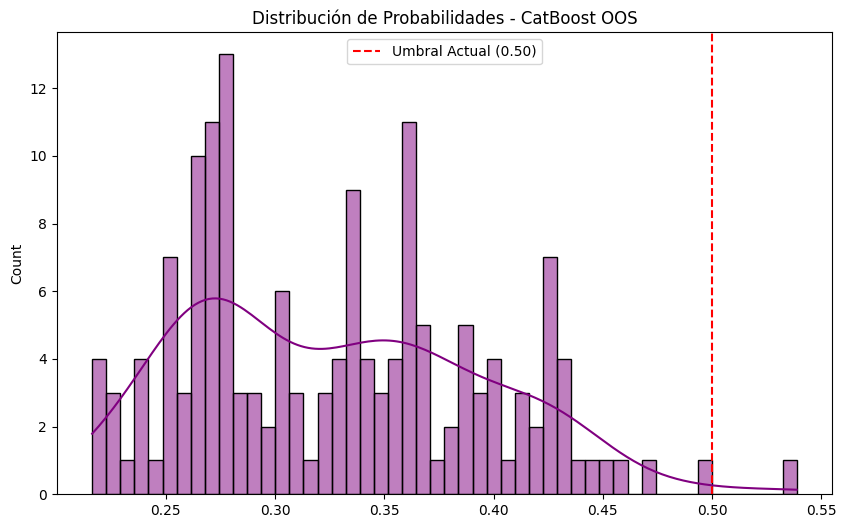

Señales con umbral 0.50: 1
Señales con umbral 0.45: 5


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
probs_oos = best_cb.predict_proba(X_oos)[:, 1]
plt.figure(figsize=(10, 6))
sns.histplot(probs_oos, bins=50, kde=True, color='purple')
plt.axvline(0.50, color='red', linestyle='--', label='Umbral Actual (0.50)')
plt.title('Distribución de Probabilidades - CatBoost OOS')
plt.legend()
plt.show()
print(f"Señales con umbral 0.50: {sum(probs_oos >= 0.50)}")
print(f"Señales con umbral 0.45: {sum(probs_oos >= 0.45)}")


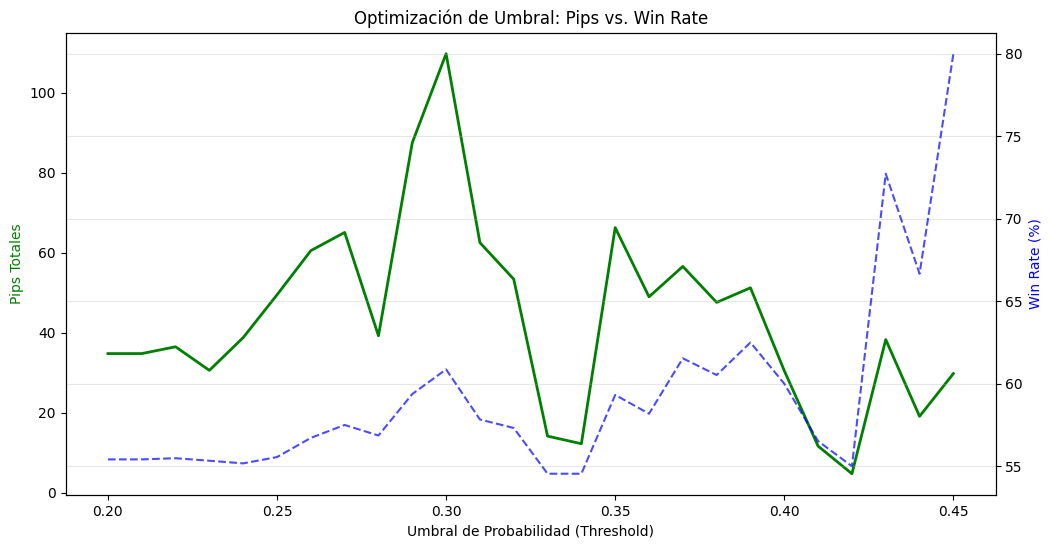

    threshold  total_pips   win_rate  trades  max_dd  pips_per_trade
10       0.30      109.75  60.869565      92   58.40        1.192935
9        0.29       87.50  59.375000      96   66.15        0.911458
15       0.35       66.25  59.322034      59   43.10        1.122881
7        0.27       65.05  57.500000     120   82.75        0.542083
11       0.31       62.50  57.831325      83   69.35        0.753012
6        0.26       60.50  56.716418     134  108.95        0.451493
17       0.37       56.55  61.538462      39   42.00        1.450000
12       0.32       53.35  57.317073      82   70.40        0.650610
19       0.39       51.20  62.500000      32   40.25        1.600000
5        0.25       49.45  55.555556     144  110.15        0.343403


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
def optimize_threshold(df_oos, model):
    features_list = ['range', 'body_size', 'rsi_14', 'rsi_slope', 'dist_ema_20', 
                     'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance', 
                     'relative_tick_intensity', 'hour']
    X_oos = df_oos.select(features_list).to_pandas()
    probs = model.predict_proba(X_oos)[:, 1]
    df_analysis = df_oos.with_columns(pl.Series(name="ml_prob", values=probs)).to_pandas()
    thresholds = np.arange(0.20, 0.51, 0.01)
    results = []
    for t in thresholds:
        filtered = df_analysis[df_analysis["ml_prob"] >= t]
        if len(filtered) < 5: continue 
        pips = filtered["pnl_pips_net"].sum()
        win_rate = (filtered["pnl_pips_net"] > 0).mean() * 100
        equity = filtered["pnl_pips_net"].cumsum()
        max_dd = (equity.cummax() - equity).max()
        results.append({
            "threshold": round(t, 2),
            "total_pips": pips,
            "win_rate": win_rate,
            "trades": len(filtered),
            "max_dd": max_dd,
            "pips_per_trade": pips / len(filtered)
        })
    return pd.DataFrame(results)
df_opt = optimize_threshold(df_final_ml_oos, best_cb)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(df_opt["threshold"], df_opt["total_pips"], 'g-', label="Pips Totales", linewidth=2)
ax2.plot(df_opt["threshold"], df_opt["win_rate"], 'b--', label="Win Rate (%)", alpha=0.7)
ax1.set_xlabel('Umbral de Probabilidad (Threshold)')
ax1.set_ylabel('Pips Totales', color='g')
ax2.set_ylabel('Win Rate (%)', color='b')
plt.title('Optimización de Umbral: Pips vs. Win Rate')
plt.grid(True, alpha=0.3)
plt.show()
print(df_opt.sort_values(by="total_pips", ascending=False).head(10))


**Generación de Señales Finales**: Aplica el mejor modelo y umbral encontrado (ej. RF > 0.25) al dataset OOS para generar la lista definitiva de trades aprobados. Guarda estos trades filtrados en un CSV (`rf_trades_longs_025.csv`) y muestra sus métricas de rendimiento finales.


In [46]:
def filter_and_save_trades_cb(df_oos, model, threshold=0.30, model_name="CatBoost", save_path="catboost_trades_filtered.csv"):
    print(f"\nFiltrando trades con {model_name} (Umbral: {threshold})...")
    features_list = [
        'range', 'body_size', 'rsi_14', 'rsi_slope', 'dist_ema_20', 
        'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance', 
        'relative_tick_intensity', 'hour'
    ]
    X_oos = df_oos.select(features_list).to_pandas()
    probs = model.predict_proba(X_oos)[:, 1]
    df_filtered = df_oos.with_columns(pl.Series(name="ml_prob", values=probs))
    df_filtered = df_filtered.filter(pl.col("ml_prob") >= threshold)
    df_filtered.write_csv(save_path)
    print(f"✅ Trades guardados exitosamente en: {save_path}")
    print(f"   Total trades seleccionados: {df_filtered.height}")
    calculate_strategy_metrics(df_filtered, f"{model_name} Filtered (Th={threshold})")
    return df_filtered
df_catboost_trades = filter_and_save_trades_cb(
    df_final_ml_oos, 
    best_cb, 
    threshold=0.30, 
    model_name="CatBoost", 
    save_path="catboost_trades_longs_030.csv"
)
print(df_catboost_trades.head())



Filtrando trades con CatBoost (Umbral: 0.3)...
✅ Trades guardados exitosamente en: catboost_trades_longs_030.csv
   Total trades seleccionados: 92
--- CatBoost Filtered (Th=0.3) Baseline Metrics ---
Trades Totales: 92
Win Rate:       60.87%
Esperanza:      1.19 pips/trade
Retorno Total:  109.75 pips
Max Drawdown:   58.40 pips
------------------------------
shape: (5, 29)
┌───────────────┬─────────┬──────────┬──────────┬───┬──────────┬──────────┬─────────────┬──────────┐
│ signal_ts     ┆ open    ┆ high     ┆ low      ┆ … ┆ mae_pips ┆ mfe_pips ┆ exit_reason ┆ ml_prob  │
│ ---           ┆ ---     ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---         ┆ ---      │
│ datetime[ms]  ┆ f64     ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ str         ┆ f64      │
╞═══════════════╪═════════╪══════════╪══════════╪═══╪══════════╪══════════╪═════════════╪══════════╡
│ 2025-07-04    ┆ 1.1558  ┆ 1.156005 ┆ 1.15556  ┆ … ┆ 0.8      ┆ 21.55    ┆ TP          ┆ 0.322616 │
│ 09:00:00      ┆  

# Random

## Distrubucion de probabilidades rf

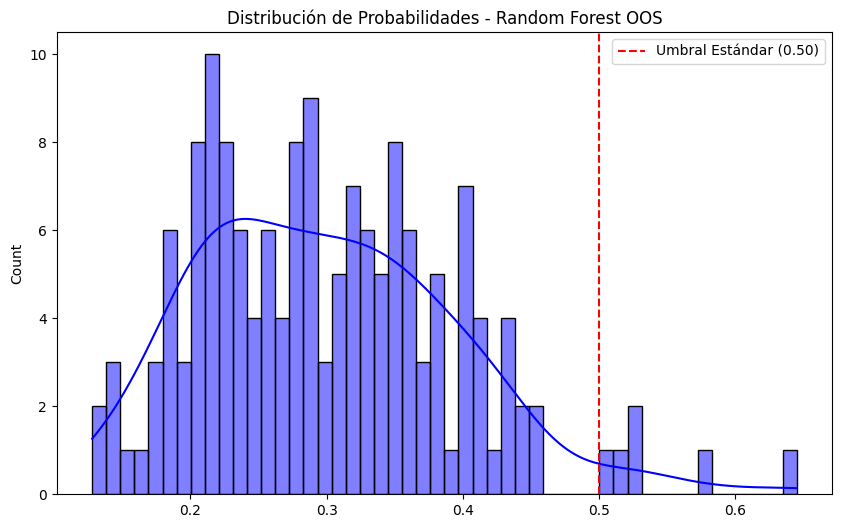

Señales RF con umbral 0.50: 6
Señales RF con umbral 0.45: 8


In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
probs_rf_oos = best_rf.predict_proba(X_oos)[:, 1]
plt.figure(figsize=(10, 6))
sns.histplot(probs_rf_oos, bins=50, kde=True, color='blue')  
plt.axvline(0.50, color='red', linestyle='--', label='Umbral Estándar (0.50)')
plt.title('Distribución de Probabilidades - Random Forest OOS')
plt.legend()
plt.show()
print(f"Señales RF con umbral 0.50: {sum(probs_rf_oos >= 0.50)}")
print(f"Señales RF con umbral 0.45: {sum(probs_rf_oos >= 0.45)}")


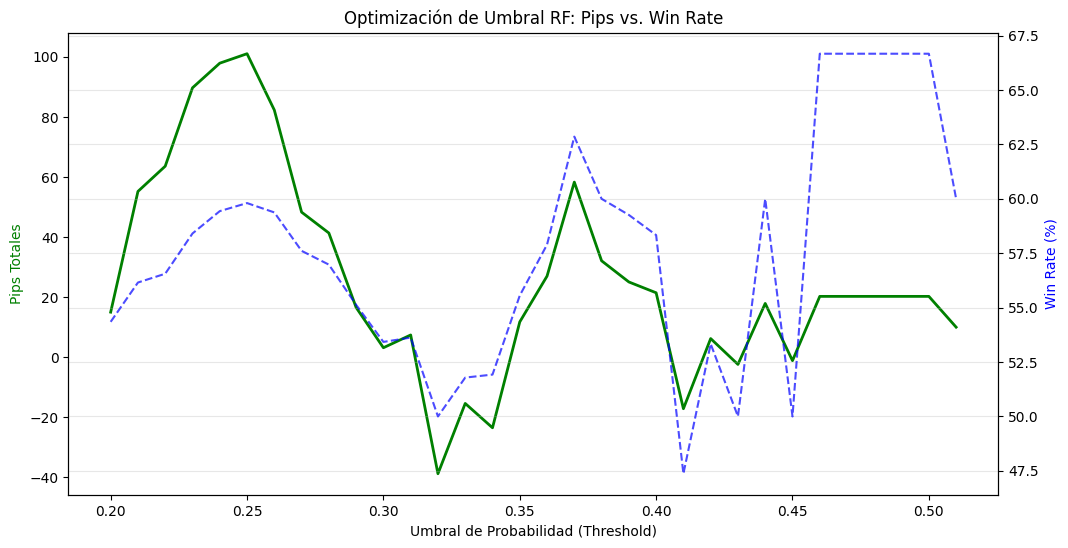

=== MEJORES UMBRALES PARA RANDOM FOREST ===
 threshold  total_pips  win_rate  trades  max_dd  pips_per_trade
      0.25      101.05 59.803922     102   72.25        0.990686
      0.24       97.90 59.433962     106   72.25        0.923585
      0.23       89.70 58.407080     113   72.25        0.793805
      0.26       82.30 59.375000      96   61.65        0.857292
      0.22       63.60 56.557377     122   72.25        0.521311
      0.37       58.30 62.857143      35   32.00        1.665714
      0.21       55.20 56.153846     130   96.05        0.424615
      0.27       48.30 57.608696      92   78.60        0.525000
      0.28       41.35 56.976744      86   68.15        0.480814
      0.38       32.10 60.000000      30   41.00        1.070000


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl 
def optimize_threshold_rf(df_oos, model):
    features_list = ['range', 'body_size', 'rsi_14', 'rsi_slope', 'dist_ema_20', 
                     'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance', 
                     'relative_tick_intensity', 'hour']
    X_oos_pd = df_oos.select(features_list).to_pandas()
    probs = model.predict_proba(X_oos_pd)[:, 1]
    df_analysis = df_oos.with_columns(pl.Series(name="ml_prob", values=probs)).to_pandas()
    thresholds = np.arange(0.20, 0.61, 0.01)
    results = []
    for t in thresholds:
        filtered = df_analysis[df_analysis["ml_prob"] >= t]
        if len(filtered) < 5: continue 
        pips = filtered["pnl_pips_net"].sum()
        win_rate = (filtered["pnl_pips_net"] > 0).mean() * 100 if len(filtered) > 0 else 0
        equity = filtered["pnl_pips_net"].cumsum()
        max_dd = (equity.cummax() - equity).max() if len(equity) > 0 else 0
        results.append({
            "threshold": round(t, 2),
            "total_pips": pips,
            "win_rate": win_rate,
            "trades": len(filtered),
            "max_dd": max_dd,
            "pips_per_trade": pips / len(filtered) if len(filtered) > 0 else 0
        })
    return pd.DataFrame(results)
df_opt_rf = optimize_threshold_rf(df_final_ml_oos, best_rf)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(df_opt_rf["threshold"], df_opt_rf["total_pips"], 'g-', label="Pips Totales (RF)", linewidth=2)
ax2.plot(df_opt_rf["threshold"], df_opt_rf["win_rate"], 'b--', label="Win Rate % (RF)", alpha=0.7)
ax1.set_xlabel('Umbral de Probabilidad (Threshold)')
ax1.set_ylabel('Pips Totales', color='g')
ax2.set_ylabel('Win Rate (%)', color='b')
plt.title('Optimización de Umbral RF: Pips vs. Win Rate')
plt.grid(True, alpha=0.3)
plt.show()
print("=== MEJORES UMBRALES PARA RANDOM FOREST ===")
print(df_opt_rf.sort_values(by="total_pips", ascending=False).head(10).to_string(index=False))


In [43]:
def filter_and_save_trades(df_oos, model, threshold=0.25, model_name="RandomForest", save_path="sf_trades_filtered.csv"):
    print(f"\nFiltrando trades con {model_name} (Umbral: {threshold})...")
    features_list = [
        'range', 'body_size', 'rsi_14', 'rsi_slope', 'dist_ema_20', 
        'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance', 
        'relative_tick_intensity', 'hour'
    ]
    X_oos = df_oos.select(features_list).to_pandas()
    probs = model.predict_proba(X_oos)[:, 1]
    df_filtered = df_oos.with_columns(pl.Series(name="ml_prob", values=probs))
    df_filtered = df_filtered.filter(pl.col("ml_prob") >= threshold)
    df_filtered.write_csv(save_path)
    print(f"✅ Trades guardados exitosamente en: {save_path}")
    print(f"   Total trades seleccionados: {df_filtered.height}")
    calculate_strategy_metrics(df_filtered, f"{model_name} Filtered")
    return df_filtered
df_rf_final_trades = filter_and_save_trades(
    df_final_ml_oos, 
    best_rf, 
    threshold=0.25, 
    model_name="RandomForest", 
    save_path="rf_trades_longs_025.csv"
)
print(df_rf_final_trades.head())



Filtrando trades con RandomForest (Umbral: 0.25)...
✅ Trades guardados exitosamente en: rf_trades_longs_025.csv
   Total trades seleccionados: 102
--- RandomForest Filtered Baseline Metrics ---
Trades Totales: 102
Win Rate:       59.80%
Esperanza:      0.99 pips/trade
Retorno Total:  101.05 pips
Max Drawdown:   72.25 pips
------------------------------
shape: (5, 29)
┌───────────────┬─────────┬──────────┬──────────┬───┬──────────┬──────────┬─────────────┬──────────┐
│ signal_ts     ┆ open    ┆ high     ┆ low      ┆ … ┆ mae_pips ┆ mfe_pips ┆ exit_reason ┆ ml_prob  │
│ ---           ┆ ---     ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---         ┆ ---      │
│ datetime[ms]  ┆ f64     ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ str         ┆ f64      │
╞═══════════════╪═════════╪══════════╪══════════╪═══╪══════════╪══════════╪═════════════╪══════════╡
│ 2025-07-04    ┆ 1.1558  ┆ 1.156005 ┆ 1.15556  ┆ … ┆ 0.8      ┆ 21.55    ┆ TP          ┆ 0.315371 │
│ 09:00:00      ┆      